In [1]:
# Built-in Python modules
import gzip
import io
import math
import os
import pickle
import shutil
import time
from collections.abc import Mapping
from contextlib import contextmanager
from copy import copy
from functools import partial
from operator import attrgetter, itemgetter
from pathlib import Path

# Third-party libraries
import fastcore.all as fc
import matplotlib as mpl
import numpy as np
import torch
from PIL import Image
import random
import timm
import torchvision
import matplotlib.pyplot as plt
from torcheval.metrics import MulticlassAccuracy

# Torchvision imports
from torchvision import transforms
import torchvision.transforms.functional as TF
import torch.nn.functional as F

# PyTorch imports
from torch import tensor, nn, optim
from torch.nn import init
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, default_collate

# Hugging Face datasets
from datasets import load_dataset, load_dataset_builder

# Fastcore foundation
from fastcore.foundation import L, store_attr

# miniai modules
from miniai.activations import *
from miniai.conv import *
from miniai.datasets import *
from miniai.init import *
from miniai.learner import *
from miniai.resnet import *
from miniai.sgd import *

In [2]:
# image URLs for demo
face_url = "https://images.pexels.com/photos/2690323/pexels-photo-2690323.jpeg?w=256"
spiderweb_url = "https://images.pexels.com/photos/34225/spider-web-with-water-beads-network-dewdrop.jpg?w=256"

In [3]:
def download_image(url):
    imgb = fc.urlread(url, decode=False)
    return torchvision.io.decode_image(tensor(list(imgb), dtype=torch.uint8)).float()/255

content_im.shape: torch.Size([3, 256, 256])


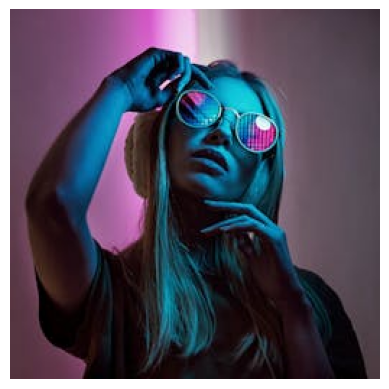

In [4]:
content_im = download_image(face_url).to(def_device)
print('content_im.shape:', content_im.shape)
show_image(content_im);

In [5]:
content_im.min(), content_im.max()

(tensor(0.), tensor(1.))

## Optimizing images

In [6]:
class LengthDataset():
    def __init__(self, length=1):
        self.length = length
    
    def __len__(self):
        return self.length
    
    def __getitem__(self, idx):
        return 0, 0

In [7]:
def get_dummy_dls(length=100):
    return DataLoaders(DataLoader(LengthDataset(length), batch_size=1), # train
                       DataLoader(LengthDataset(1), batch_size=1))      # valid (length 1)

In [8]:
class TensorModel(nn.Module):
    def __init__(self, t):
        super().__init__()
        self.t = nn.Parameter(t.clone())
    
    def forward(self, x = 0):
        return self.t

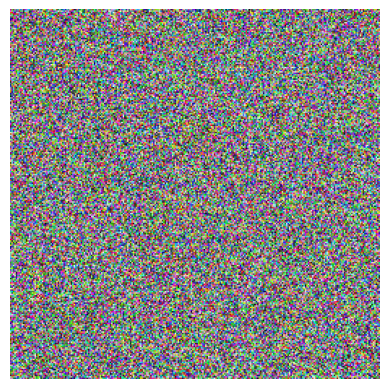

In [9]:
model = TensorModel(torch.rand_like(content_im))
show_image(model());

In [10]:
[p.shape for p in model.parameters()]

[torch.Size([3, 256, 256])]

loss,epoch,train
0.041,0,train
0.001,0,eval


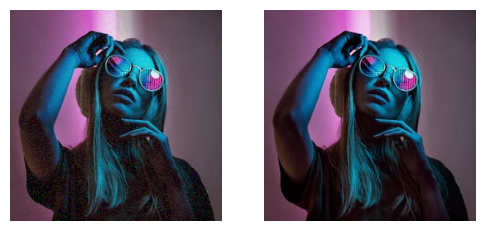

In [11]:
class ImageOptCB(TrainCB):
    def predict(self, learn): learn.preds = learn.model()
    def get_loss(self, learn): learn.loss = learn.loss_func(learn.preds)

def loss_fn_mse(im):
    return F.mse_loss(im, content_im)

model = TensorModel(torch.rand_like(content_im))
cbs = [ImageOptCB(), ProgressCB(), MetricsCB(), DeviceCB()]
learner = Learner(model, get_dummy_dls(100), loss_fn_mse, 
                lr=1e-2, cbs=cbs, opt_func=torch.optim.Adam)
learner.fit(1)

# result (left) vs target image (right)
show_images([learner.model().clip(0, 1), content_im]);

In [12]:
class ImageOptCB(TrainCB):
    def predict(self, learner):
        learner.preds = learner.model()

    def get_loss(self, learner):
        learner.loss = learner.loss_func(learner.preds)

In [13]:
def loss_fn_mse(im):
    return F.mse_loss(im, content_im)

In [14]:
model = TensorModel(torch.rand_like(content_im))
cbs = [ImageOptCB(), ProgressCB(), MetricsCB(), DeviceCB()]
learner = Learner(model, get_dummy_dls(100), loss_fn_mse, lr=1e-2, cbs=cbs, opt_func=torch.optim.Adam)
learner.fit(1)

loss,epoch,train
0.042,0,train
0.001,0,eval


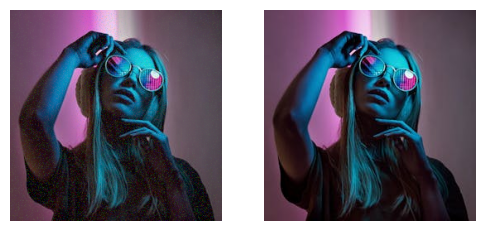

In [15]:
show_images([learner.model().clip(0, 1), content_im]);

## Viewing progress

It would be great if we could see what is happening over time. You could save individual images and turn them into a video, but for quick feedback we can also log images every few iterations and display them in a grid in `after_fit`:

In [16]:
class ImageLogCB(Callback):
    order = ProgressCB.order + 1

    def __init__(self, log_every=10):
        store_attr(); self.images=[]; self.i=0

    def after_batch(self, learner):
        if self.i % self.log_every == 0:
            self.images.append(to_cpu(learner.preds.clip(0, 1)))
        self.i += 1

    def after_fit(self, learner):
        show_images(self.images)

loss,epoch,train
0.028,0,train
0.000,0,eval


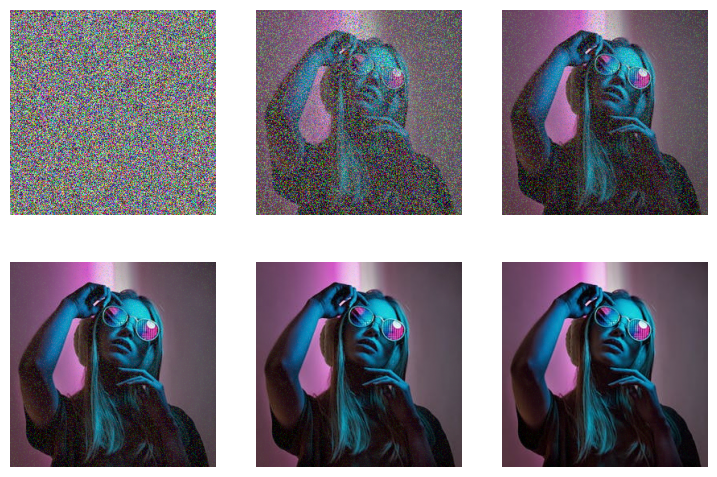

In [17]:
model = TensorModel(torch.rand_like(content_im))
learner = Learner(model, get_dummy_dls(150), loss_fn_mse, lr=1e-2, cbs=cbs, opt_func=torch.optim.Adam)
learner.fit(1, cbs=[ImageLogCB(30)])

## Getting features from VGG16

We're going to peek inside a small CNN and extract the outputs of different layers.

![vgg diag](https://neurohive.io/wp-content/uploads/2018/11/vgg16-1-e1542731207177.png)

In [18]:
print(timm.list_models('*vgg*'))

['repvgg_a0', 'repvgg_a1', 'repvgg_a2', 'repvgg_b0', 'repvgg_b1', 'repvgg_b1g4', 'repvgg_b2', 'repvgg_b2g4', 'repvgg_b3', 'repvgg_b3g4', 'repvgg_d2se', 'vgg11', 'vgg11_bn', 'vgg13', 'vgg13_bn', 'vgg16', 'vgg16_bn', 'vgg19', 'vgg19_bn']


In [19]:
vgg16 = timm.create_model('vgg16', pretrained=True).to(def_device).features

model.safetensors:   0%|          | 0.00/553M [00:00<?, ?B/s]

In [20]:
vgg16

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_si

## Normalize images

This model expects images normalized with the same stats as those used during training, which in this case requires the stats of the ImageNet dataset. Previously we were working with single-channel images, and so normalizing was pretty straightforward. With three channels, we need to think a bit more about shapes and boradcasting rules:

In [21]:
imagenet_mean = tensor([0.485, 0.456, 0.406])
imagenet_std = tensor([0.229, 0.224, 0.225])

In [22]:
# Try 1 (won't work):
(content_im - imagenet_mean) / imagenet_std

RuntimeError: The size of tensor a (256) must match the size of tensor b (3) at non-singleton dimension 2

In [23]:
imagenet_mean.shape

torch.Size([3])

In [24]:
content_im.shape

torch.Size([3, 256, 256])

In [25]:
imagenet_mean[:,None,None].shape

torch.Size([3, 1, 1])

In [26]:
def normalize(im):
    imagenet_mean = tensor([0.485, 0.456, 0.406])[:,None,None].to(im.device)
    imagenet_std = tensor([0.229, 0.224, 0.225])[:,None,None].to(im.device)
    return (im - imagenet_mean) / imagenet_std

In [27]:
normalize(content_im).min(), normalize(content_im).max()

(tensor(-2.1179), tensor(2.6400))

In [28]:
normalize(content_im).mean(dim=(1, 2))

tensor([-0.9724, -0.9594, -0.4191])

In [29]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

In [30]:
normalize(content_im).min(), normalize(content_im).max()

(tensor(-2.1179), tensor(2.6400))